In [15]:
import vit as vit
import utils
import visualize
import importlib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_addons as tfa

In [ ]:
data = np.load("../../data/train_npz/case0007_slice085.npz")
image = data["image"]
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
X = vit.preprocess_inputs(image).reshape(1, image_size, image_size, 3)

In [ ]:
%%time 
y = model.predict(X)
y.shape

In [11]:
# y

In [13]:
patches = y.reshape((1, 1024, 16, 16, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


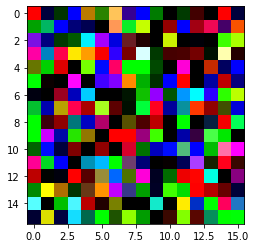

In [19]:
plt.imshow(patches[0, 60, :, :, :])

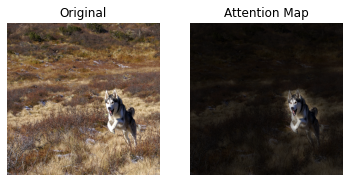

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load a model
image_size = 384
classes = utils.get_imagenet_classes()
model = vit.vit_b16(
    image_size=image_size,
    pretrained=True,
    include_top=True,
    pretrained_top=True
)
classes = utils.get_imagenet_classes()

# Get an image and compute the attention map
url = 'https://upload.wikimedia.org/wikipedia/commons/b/bc/Free%21_%283987584939%29.jpg'
image = utils.read(url, image_size)
attention_map = visualize.attention_map(model=model, image=image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

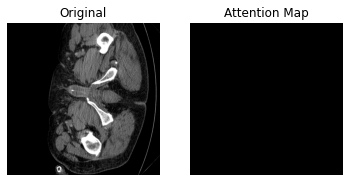

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Load a model
image_size = 512
model = vit.vit_b16(
    image_size=image_size,
    pretrained=True,
    include_top=True,
    pretrained_top=True
)
data = np.load("../../data/train_npz/case0007_slice005.npz")
image = data["image"]
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
# X = vit.preprocess_inputs(image).reshape(1, image_size, image_size, 3)
attention_map = visualize.attention_map(model=model, image=image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map, cmap="viridis")

# Test Model with upsampling 

In [ ]:
_1hot_label = tf.reshape(tf.one_hot(data["label"], depth=9), [1, 512, 512, 9])
_1hot_label.shape

In [117]:
importlib.reload(vit)
transunet = vit.vit_b16(image_size, pretrained=True)
optimizer = tfa.optimizers.SGDW(weight_decay=1e-4, momentum=.9, learning_rate=0.01)
transunet.compile(optimizer=optimizer, loss=[vit.segmentation_loss])

In [118]:
transunet.fit(x=X, y=_1hot_label, epochs=1, batch_size=1, verbose=1)

1/1 [==============================] - 23s 23s/step - loss: 1.4821


In [116]:
label = transunet(X)
label.shape

TensorShape([1, 512, 512, 9])

In [33]:
np.unique(data["label"])

array([0., 1., 2., 3., 4., 5., 6., 7., 8.], dtype=float32)

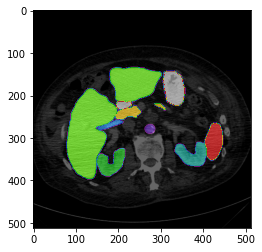

In [44]:
plt.figure()
plt.imshow(data['image'].T, cmap='gray') 
plt.imshow(data['label'].T, cmap='nipy_spectral', alpha=0.6) 
plt.show()

## Test with more data 

In [184]:
case_id, n_slices = 5, 10
image_3d, label_3d = [], []
for slice in range(80,90,1):
    i = str(slice) if slice > 99 else "0" + str(slice) if slice >9 else "00" + str(slice)
    data = np.load(f"../../data/train_npz/case000{case_id}_slice{i}.npz")
    image = cv2.cvtColor(data["image"], cv2.COLOR_GRAY2RGB)
    X = vit.preprocess_inputs(image)
    image_3d.append(X)
    label_3d.append(tf.one_hot(data['label'], depth=9))
image_3d = np.array(image_3d)
label_3d = np.array(label_3d)

In [142]:
label_3d.shape

(117, 512, 512, 9)

In [135]:
train_dataset = tf.data.Dataset.from_tensor_slices((image_3d, label_3d))

In [191]:
importlib.reload(vit)
transunet = vit.vit_b16(image_size, pretrained=True)
optimizer = tfa.optimizers.SGDW(weight_decay=1e-4, momentum=.9, learning_rate=0.01)
transunet.compile(optimizer=optimizer, loss=[vit.segmentation_loss])
transunet.fit(x=image_3d, y=label_3d, epochs=5, batch_size=2, verbose=1)

Epoch 1/5
1/5 [=====>........................] - ETA: 1:56 - loss: 2.0401

ResourceExhaustedError:  OOM when allocating tensor with shape[2,262144,9] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node segmentation_loss/PartitionedCall/PartitionedCall/mul_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_347190]

Function call stack:
train_function


In [150]:
train_sample = np.load(f"../../data/train_npz/case0005_slice001.npz")
image, true_label = train_sample["image"],  train_sample["label"]
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB).reshape(1,512,512,3)
X = vit.preprocess_inputs(image)

In [160]:
pred_label = transunet(X)

In [163]:
pred_label_test = tf.math.argmax(tf.nn.softmax(pred_label, axis=3), axis=3)

In [164]:
pred_label_test.shape

TensorShape([1, 512, 512])

In [167]:
pred = pred_label_test.numpy()

In [165]:
tf.math.equal(true_label.reshape(1,512,512), pred_label_test)

<tf.Tensor: shape=(1, 512, 512), dtype=bool, numpy=
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])>

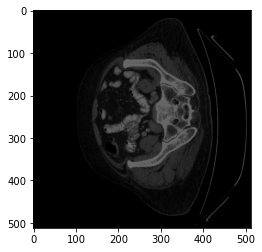

In [170]:
plt.figure()
plt.imshow(train_sample["image"], cmap='gray') 
plt.imshow(pred[0], cmap='nipy_spectral', alpha=0.6) 
plt.show()

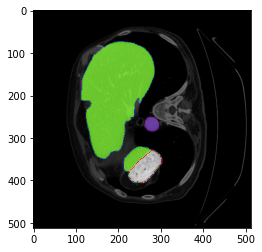

In [183]:
train_sample = np.load(f"../../data/train_npz/case0005_slice085.npz")
plt.figure()
plt.imshow(train_sample["image"], cmap='gray') 
plt.imshow(train_sample["label"], cmap='nipy_spectral', alpha=0.6) 
plt.show()